# Powertrain Analysis
*BeamNG.tech / BeamNG.drive*

## Introduction

This example will demonstrate how to use the powertrain sensor to analyse properties of a vehicle's powertrain.  The powertrain data can be requested from BeamNGpy either i) as soon is it is available in the simulator, up to 2000 times per second, or ii) in bulk, returned later - this is more efficient but is only suitable for a posteriori processing of the data.  Here we will use the latter mode to plot some graphs.

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from time import sleep
from beamngpy import BeamNGpy, Scenario, Vehicle
from beamngpy.sensors import PowertrainSensor

sns.set()

The actual scenario will be set up by instantiating the `Scenario` class with an instance set on `west_coast_usa` that we name "driver_comfort". Two instances of the `Vehicle` class will be created using the ETK800 model and given unique names for later reference.

In [8]:
beamng = BeamNGpy('localhost', 64256)
beamng.open()

scenario = Scenario('west_coast_usa', 'powertrain_analysis')

careful = Vehicle('careful', model='etk800', licence='CAREFUL', colour='Green')
aggressive = Vehicle('aggressive', model='etk800', licence='AGGRO', colour='Red')

We add the vehicles to our scenario and start the scenario. The locations they are placed were determined manually in the game's World Editor. The call to `scenario.make(beamng)` creates files necessary for the game to load our scenario during the simulation.

In [9]:
scenario.add_vehicle(careful, pos=(-767.1, 402.8, 142.8), rot_quat=(0, 0, 0.027, 1))
scenario.add_vehicle(aggressive, pos=(-770.1, 398.8, 142.8), rot_quat=(0, 0, 0.027, 1))

scenario.make(beamng)
beamng.load_scenario(scenario)
beamng.set_deterministic()
beamng.set_steps_per_second(60)
beamng.start_scenario()

With two vehicles instantiated we move on to setting up a powertrain sensors for each of the two vehicles.  We set both powertrain sensors to take a sample (reading) from the simulator every 0.001s (1ms).  This can be reduced to as low as 0.5ms, if required.

In [10]:
careful_pt = PowertrainSensor('careful_sensor', beamng, careful, is_send_immediately=False, physics_update_time=0.001)
aggressive_pt = PowertrainSensor('aggressive_sensor', beamng, aggressive, is_send_immediately=False, physics_update_time=0.001)

We further set up some lists which will contain dimension-wise measurement data for both vehicles. We also store the time-stamps.

In [11]:
careful_data_x = []
careful_data_y = []
careful_data_t = []
aggressive_data_x = []
aggressive_data_y = []
aggressive_data_t = []

## Running

After our scenario is loaded in the simulator, we start the scenario letting the aggressive vehicle drive to its destination first, using a high maximum speed and high aggression value. Afterwards, the careful vehicle is given the same destination but a lower speed limit and lower aggression value.

In [12]:
beamng.switch_vehicle(aggressive)  # Switches the game's focus to the aggressive vehicle. No effect besides making it easier to watch.

aggressive.ai_set_waypoint('junction1_wp24')
aggressive.ai_set_speed(50, mode='limit')
aggressive.ai_set_aggression(1)
sleep(5)  # A little pause before we start

for t in range(0, 2000):
    readings = aggressive_pt.poll()
    for i in range(0, len(readings)):
        aggressive_data_x.append(readings[i]['mainEngine']['outputTorque1'])
        aggressive_data_y.append(readings[i]['driveshaft']['outputTorque1'])
        aggressive_data_t.append(readings[i]['time'])                                        # The time stamp for this reading.

aggressive.ai_set_waypoint('tunnel_NE_A_1')  # Make it move away to make room for the careful car.

beamng.switch_vehicle(careful)  # Switches the game's focus to the careful vehicle. No effect besides making it easier to watch.

careful.ai_set_waypoint('junction1_wp24')
careful.ai_set_speed(10, mode='limit')
careful.ai_set_aggression(0.3)
sleep(5)  # A little pause before we start

for t in range(0, 2000):
    readings = careful_pt.poll()
    for i in range(0, len(readings)):
        careful_data_x.append(readings[i]['mainEngine']['outputTorque1'])
        careful_data_y.append(readings[i]['driveshaft']['outputTorque1'])
        careful_data_t.append(readings[i]['time'])                                        # The time stamp for this reading.

careful_pt.remove()         # remove the powertrain sensors from the vehicles.
aggressive_pt.remove()
beamng.close()              # Close beamng as all data was gathered.

## Plotting

In this example we plot the output torques from the main engine and driveshaft (properties from the powertrain sensor for the selected vehicles).

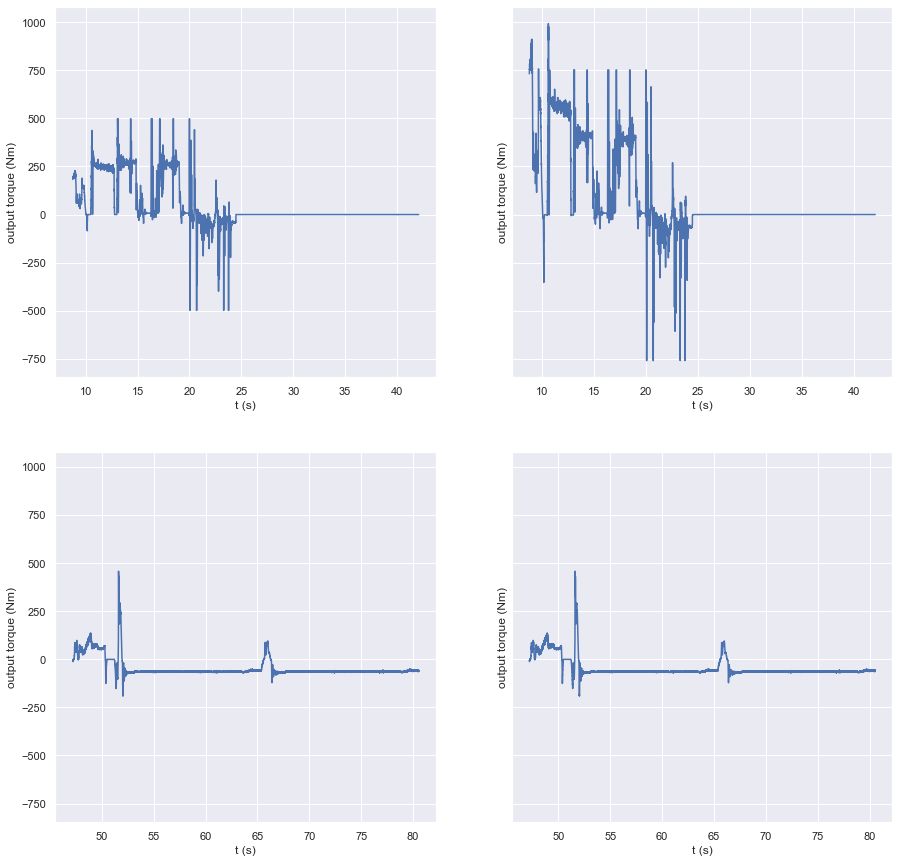

In [13]:
figure, ax = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
ax[0, 0].plot(aggressive_data_t, aggressive_data_x, 'b-')
ax[0, 0].set_xlabel('t (s)')
ax[0, 0].set_ylabel('output torque (Nm)')
ax[0, 1].plot(aggressive_data_t, aggressive_data_y, 'b-')
ax[0, 1].set_xlabel('t (s)')
ax[0, 1].set_ylabel('output torque (Nm)')
ax[1, 0].plot(careful_data_t, careful_data_x, 'b-')
ax[1, 0].set_xlabel('t (s)')
ax[1, 0].set_ylabel('output torque (Nm)')
ax[1, 1].plot(careful_data_t, careful_data_x, 'b-')
ax[1, 1].set_xlabel('t (s)')
ax[1, 1].set_ylabel('output torque (Nm)')
plt.show()